In [251]:
import pandas as pd
import geopandas as gpd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from statsmodels.tools.tools import add_constant
import numpy as np

### Load data

Load dataset with snapshot of 2014 pipeline snapshot and outcomes.

In [7]:
mv_history = pd.read_csv('./data/pipeline_history.csv')

In [15]:
mv_history.head()

,Address,Pg,Built,Units
0,420 San Antonio,3,1.00,373
1,2580 California St,4,0.26,632
2,1701 ECR,7,1.00,24
3,1101 ECR,8,1.00,52
4,801 ECR,8,1.00,164


Load site inventory datasets.

In [ ]:
si_geo = gpd.read_file('./data/MV_Site_Inventory/MV_Site_Inventory.shp')

In [66]:
si = pd.read_csv('./data/hcd_table_a.csv', low_memory=False)
si = si[~si.isna().all(axis=1)]
si = si[:-1]

In [303]:
newer_permits = gpd.read_file('./data/newer_permits.json')

In [252]:
ABAG = None
def load_abag_permits() -> gpd.GeoDataFrame:
    """
    Loads all 2013-2017 building permits from ABAG as a GeoDataFrame.
    """
    global ABAG
    if ABAG is None:
        geometry_df = gpd.read_file("./data/abag_permits/permits.shp")
        data_df = pd.read_csv("./data/abag_permits/permits.csv")

        # There shouldn't be any rows with geometry data that don't have label data
        assert geometry_df["joinid"].isin(data_df["joinid"]).all()

        ABAG = gpd.GeoDataFrame(data_df.merge(geometry_df, how="left", on="joinid"))

    # Filter out permits from before the start of the 5th Housing Element cycle.
    ABAG = ABAG[ABAG['permyear'] >= 2015].copy()

    ABAG['apn'] = ABAG['apn'].replace({np.nan: None})

    return ABAG

In [264]:
abag_perms = load_abag_permits()
older_permits = abag_perms[(abag_perms['jurisdictn'] == 'Mountain View')]

In [265]:
older_permits.columns

Index(['objectid', 'joinid', 'permyear', 'county', 'jurisdictn', 'apn',
       'address', 'zip', 'projname', 'hcategory', 'vlowdr', 'vlowndr',
       'vlowtot', 'lowdr', 'lowndr', 'lowtot', 'moddr', 'modndr', 'modtot',
       'amodtot', 'totalunit', 'tenure', 'mapped', 'mapnotes', 'pda',
       'pdacycle', 'pdajoinid', 'tpa', 'tpacycle', 'hsngsite', 'rhnacycle',
       'notes', 'ObjectId2', 'OBJECTID', 'geometry'],
      dtype='object')

In [273]:
zoning = gpd.read_file('./data/Zoning_Districts/Zoning_Districts.shp')

### Pipeline History Analysis

In [14]:
sum(mv_history.Units * mv_history.Built) / mv_history.Units.sum()

0.6719286871961102

In [16]:
pearsonr(mv_history.Units, mv_history.Built)

(-0.24156975644156864, 0.3048589611212049)

### Pipeline Predictions

In [153]:
reg = sm.Logit(mv_history.Built, add_constant(mv_history.Units)).fit_regularized()

def predict_success(n_units):
    """P(devs) adjusted for number of units in project."""
    return reg.predict([1, n_units])

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4578744955743205
            Iterations: 50
            Function evaluations: 480
            Gradient evaluations: 50


In [154]:
def predict_success_floor(n_units):
    """
    P(devs) adjusted for number of units in project, with a floor that 
    pipeline sites are at least as likely to be developed as opportunity sites.
    """
    return max(reg.predict([1, n_units]), .206)

In [91]:
pipeline = si[si['Optional Information 1'].str.contains('Pending')]

This dataset excludes approved projects, which is why it has less total capacity than the draft claims.

In [139]:
pipeline['Total Capacity'].sum()

6913.0

In [99]:
pipeline['Site Status'].value_counts()

Pending Project    66
Name: Site Status, dtype: int64

#### Pipeline capacity with plain Logistic Regression

In [171]:
n_approved_units = 1847
n_approved_li_units = 226
p_devs = pipeline['Total Capacity'].apply(predict_success)

In [172]:
sum(p_devs * pipeline['Total Capacity']).item() + n_approved_units

3961.4157200269683

In [173]:
sum(p_devs * pipeline['Lower Income Capacity']).item() + n_approved_li_units

1145.655594727962

1847 is the number of total units in approved projects. This capacity is excluded from excel sheet.

#### Pipeline capacity with constraint that P(dev | pipeline) > P(dev | opp) for all sites

In [174]:
p_devs = pipeline['Total Capacity'].apply(predict_success_floor)

In [175]:
sum(p_devs * pipeline['Total Capacity']).item() + n_approved_units

4651.169153669649

In [176]:
sum(p_devs * pipeline['Lower Income Capacity']).item() + n_approved_li_units

1253.8843652965609

### Opportunity Sites

In [181]:
opps = si[~si['Site Status'].str.contains('Pending')]

(array([20., 28.,  8., 21.,  8.,  3.,  2.,  1.,  0.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([0.1  , 0.362, 0.624, 0.886, 1.148, 1.41 , 1.672, 1.934, 2.196,
        2.458, 2.72 , 2.982, 3.244, 3.506, 3.768, 4.03 , 4.292, 4.554,
        4.816, 5.078, 5.34 , 5.602, 5.864, 6.126, 6.388, 6.65 , 6.912,
        7.174, 7.436, 7.698, 7.96 ]),
 <BarContainer object of 30 artists>)

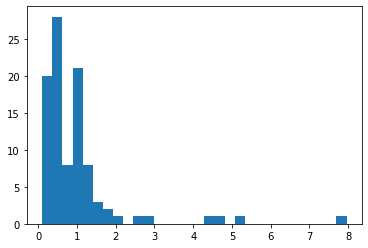

In [185]:
plt.hist(opps['Parcel Size (Acres)'], bins=30)

In [186]:
sum(opps['Parcel Size (Acres)'] < .5)

34

In [197]:
opps['Zoning Designation (Current)'].value_counts()

P(38) - El Camino Real Precise Plan    55
P(41) - East Whisman Precise Plan      15
P(40) - San Antonio Precise Plan        9
P(39) - North Bayshore Precise Plan     6
CN                                      5
CRA                                     4
P(27) - Grant-Phyllis Precise Plan      2
P(19) - Downtown Precise Plan           1
Name: Zoning Designation (Current), dtype: int64

In [204]:
ecr = opps[opps['Zoning Designation (Current)'].str.contains("El Camino Real")]

In [205]:
ew = opps[opps['Zoning Designation (Current)'].str.contains("East Whisman")]

In [206]:
sa = opps[opps['Zoning Designation (Current)'].str.contains("San Antonio")]

In [207]:
nb = opps[opps['Zoning Designation (Current)'].str.contains("North Bayshore")]

In [211]:
len(ecr), len(ew), len(sa), len(nb)

(55, 15, 9, 6)

55 projects in 8 years for ecr
15 projects in 8 years for ew
9 projects in 8 years for sa
6 projects in 8 years for nb


In [267]:
newer_permits[newer_permits['Address'].str.lower().str.contains('el camino')].shape

(13, 48)

In [271]:
older_permits[older_permits['address'].str.lower().str.contains('el camino')].shape

(4, 35)

Half of older permits have same geometry.

In [282]:
older_permits.geometry.drop_duplicates().unique()

5650     POINT (-122.05588 37.39211)
5651     POINT (-122.05588 37.39211)
5652     POINT (-122.05588 37.39211)
5653     POINT (-122.05588 37.39211)
5654     POINT (-122.05588 37.39211)
                    ...             
19410    POINT (-122.09941 37.39504)
19457    POINT (-122.08958 37.39400)
19458    POINT (-122.09809 37.38968)
19459    POINT (-122.10081 37.40186)
19460    POINT (-122.10063 37.40118)
Name: geometry, Length: 486, dtype: geometry

In [314]:
pp_permits_new = gpd.sjoin(newer_permits, zoning.to_crs('EPSG:4326'))['PRECPLAN'].value_counts()

In [315]:
pp_permits_old = gpd.sjoin(older_permits, zoning.to_crs('EPSG:4326'))['PRECPLAN'].value_counts()

In [335]:
ecr_ppid = 'P(38)'
nbs_ppid = 'P(39)'
sa_ppid = 'P(40)'
ew_ppid = 'P(41)'

In [336]:
pp_permits_new[ecr_ppid] + pp_permits_old[ecr_ppid]

36

In [337]:
pp_permits_new[nbs_ppid]

2

In [338]:
pp_permits_new[sa_ppid] + pp_permits_old[sa_ppid]

10

In [339]:
pp_permits_new[ew_ppid] + pp_permits_old[ew_ppid]

4

In [341]:
for pp, name in zip([ecr, ew, sa, nb], ['ecr', 'ew', 'sa', 'nb']):
    print(len(pp), 'projects in 8 years for', name)

55 projects in 8 years for ecr
15 projects in 8 years for ew
9 projects in 8 years for sa
6 projects in 8 years for nb


In [345]:
newer_permits['Reporting Year'].value_counts()

2021    317
2019    138
2020    126
2018     39
Name: Reporting Year, dtype: int64

In [346]:
older_permits['permyear'].value_counts()

2017    303
2016    174
2015      9
Name: permyear, dtype: int64